<a href="https://colab.research.google.com/github/ThomasLane1820/Prediction-of-Product-Sales/blob/main/Prediction_of_Product_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Product Sales
- Author: Thomas Lane


## Project overview

## Load and Inspect Data

### Imports

In [374]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')
# Importing required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingRegressor
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Info

In [375]:

fpath = '/content/drive/MyDrive/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv'
df = pd.read_csv(fpath)

In [376]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [377]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


- There are 8,523 rows, and 12 columns. There are 7 categorical/string columns and 5 numerical columns.

In [378]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


## Data Cleaning

#### Duplicated Data

In [379]:
# Creating a filter that identifies duplicated rows.
duplicated_rows = df.duplicated()
# finding the sum of duplicated rows.
duplicated_rows.sum()

np.int64(0)

- There are no duplicated rows.
- Now it's time to check and see if there are any missing values.

#### Missing Values

In [380]:
# getting the number of null values in each column and saving it as a variable.
null_values = df.isna().sum()
null_values

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


- The only columns that have nulls are "Item_weight" abd "Outlet_Size", and they each have over 1000 nulls. I'll address this by using placeholder values.

In [381]:
# Attempting to find out what the missing "Outlet_Size" values may be
df[df["Outlet_Size"].isna()]["Outlet_Type"].value_counts()

,count
Outlet_Type,
Supermarket Type1,1855
Grocery Store,555


In [382]:
df["Outlet_Size"].value_counts()

,count
Outlet_Size,
Medium,2793
Small,2388
High,932


In [383]:
# Checking how an "Outlet_Type" of 'Grocery Store' corresponds wiht Outlet_Size
df.loc[df["Outlet_Type"] == "Grocery Store", "Outlet_Size"].value_counts()

,count
Outlet_Size,
Small,528


In [384]:
# Filling the missing "Outlet_Size" values with their appropriate values
df.loc[df["Outlet_Type"] == "Grocery Store", "Outlet_Size"] = "Small"
df[df["Outlet_Size"].isna()]["Outlet_Type"].value_counts()

,count
Outlet_Type,
Supermarket Type1,1855


In [385]:
df["Outlet_Size"].value_counts()

,count
Outlet_Size,
Small,2943
Medium,2793
High,932


In [386]:
# Attempting to find a correlation between the missing "Outlet_Size" values
df[df["Outlet_Size"].isna()]["Outlet_Location_Type"].value_counts()

,count
Outlet_Location_Type,
Tier 2,1855


In [387]:
# Checking what values of "Outlet_Size" correspond with an "Outlet_location_Type" value of 'Tier 2'
df[df["Outlet_Location_Type"] == "Tier 2"]["Outlet_Size"].value_counts()

,count
Outlet_Size,
Small,930


In [388]:
# Filling the missing "Outlet_Size" values with their appropriate values
df.loc[df["Outlet_Location_Type"] == "Tier 2", "Outlet_Size"] = "Small"
df[df["Outlet_Size"].isna()]["Outlet_Type"].value_counts()

,count
Outlet_Type,


In [389]:
df["Outlet_Size"].value_counts()

,count
Outlet_Size,
Small,4798
Medium,2793
High,932


In [390]:
df["Outlet_Size"].value_counts()

,count
Outlet_Size,
Small,4798
Medium,2793
High,932


In [391]:
# Replacing the missing "Item_Weight" values with the placeholder value of (-1).
df["Item_Weight"] = df["Item_Weight"].fillna(-1)

In [392]:
# Verifying that all missing values were properly replaced.
null_values = df.isna().sum()
null_values

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0


- There are no more missing null values in our data set.
- Now to check and see if there are any inconsistent data categories.

#### Data Inconsistencies

##### Categorical inconsistencies

In [393]:
# Saving a list of object columns
string_cols = df.select_dtypes('object').columns
string_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [394]:
# Checking the number of unique values in each object column.
df[string_cols].nunique()

,0
Item_Identifier,1559
Item_Fat_Content,5
Item_Type,16
Outlet_Identifier,10
Outlet_Size,3
Outlet_Location_Type,3
Outlet_Type,4


In [395]:
# Checking the percentage of unique values to ensure nothing is too our of the ordinary
df[string_cols].nunique() / len(df) * 100

,0
Item_Identifier,18.291681
Item_Fat_Content,0.058665
Item_Type,0.187727
Outlet_Identifier,0.117330
Outlet_Size,0.035199
Outlet_Location_Type,0.035199
Outlet_Type,0.046932


In [396]:
# loop through the list of string columns
for col in string_cols:
  # print the value counts for the column
  print(f'Value counts for {col}')
  print(df[col].value_counts())
  # Printing an empty line for readability
  print('\n')

Value counts for Item_Identifier
Item_Identifier
FDW13    10
FDG33    10
FDX31     9
FDT07     9
NCY18     9
         ..
FDO33     1
FDK57     1
FDT35     1
FDN52     1
FDE52     1
Name: count, Length: 1559, dtype: int64


Value counts for Item_Fat_Content
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64


Value counts for Item_Type
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64


Value counts for Outlet_Identifier
Outlet_Identifier
OUT027    935
OUT013

- Using this method we can see a there are a few inconsistencies in Item_Fat_Content. Where Low fat, LF, low fat, reg, Regular can be simplified
- Along with weird phrasing in Outlet_Size where it goes from Small, Medium, and High.

In [397]:
# Replacing "LF" and "low fat" with "Low Fat" in Item_Fat_Content.
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat',
                                                         'low fat': 'Low Fat'})
df['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5517
Regular,2889
reg,117


In [398]:
# Replacing "reg" with "Regular".
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'reg': 'Regular'})
# Ensuring that the oddities are resovled
df['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5517
Regular,3006


In [399]:
# Replacing "High" with "Large" in Outlet_Size for sizing terminology consistency
df['Outlet_Size'] = df['Outlet_Size'].replace({'High': 'Large'})
# Ensuring that the oddities are resovled
df['Outlet_Size'].value_counts()

,count
Outlet_Size,
Small,4798
Medium,2793
Large,932


- Now all inconsistencies in Item_Fat_Content are resolved.
- While there were no clear oddities in Outlet_Size and the "fix" was largely preferential, that column is also resolved.

- The "Item_Identifier" column can be split into two separate columns. One for Item category: FD, DR, or NC and the other for Item Identifier.

In [400]:
# Splitting the "Item_Identifier" column into two separate columns
df['Item_Category'] = df['Item_Identifier'].str[0:2]
df['Item_Identifier'] = df['Item_Identifier'].str[2:]

In [401]:
# Moving the two new columns to the fron of the dataframe
# assigning the column to move to a varaible
col_to_move = df.pop('Item_Category')

# Inserting column into the second position
df.insert(0, 'Item_Category', col_to_move)

In [402]:
df.head()

,Item_Category,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FD,A15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DR,C01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FD,N15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FD,X07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NC,D19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,Large,Tier 3,Supermarket Type1,994.7052


- Now that the column has bee split, I can change all NC (non-consumable) items from low-fat to NC.

In [403]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].where(df['Item_Category'] != 'NC',
                            df['Item_Fat_Content'].replace({'Low Fat': 'NC'}))

In [404]:
df.head()

,Item_Category,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FD,A15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DR,C01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FD,N15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FD,X07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NC,D19,8.93,NC,0.000000,Household,53.8614,OUT013,1987,Large,Tier 3,Supermarket Type1,994.7052


- The food categorization issues have been resolved.
- Now it's time to check for any numerical inconsistencies.

##### Numerical Inconsistencies

In [405]:
# Saving a list of numerical columns
num_cols = df.select_dtypes('number').columns
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [406]:
# Using .describe() to view the statistics of our data
for col in num_cols:
  # print the description of each column
  print(f'Value counts for {col}')
  print(df[col].describe())
  # Print an empty line for readability
  print('\n')

Value counts for Item_Weight
count    8523.000000
mean       10.478936
std         6.720742
min        -1.000000
25%         6.650000
50%        11.000000
75%        16.000000
max        21.350000
Name: Item_Weight, dtype: float64


Value counts for Item_Visibility
count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64


Value counts for Item_MRP
count    8523.000000
mean      140.992782
std        62.275067
min        31.290000
25%        93.826500
50%       143.012800
75%       185.643700
max       266.888400
Name: Item_MRP, dtype: float64


Value counts for Outlet_Establishment_Year
count    8523.000000
mean     1997.831867
std         8.371760
min      1985.000000
25%      1987.000000
50%      1999.000000
75%      2004.000000
max      2009.000000
Name: Outlet_Establishment_Year, dtype: float64


Value counts for Item_Outlet_Sales
cou

- Upon first inspection the numerical columns seems to not have any apparent inconsistencies or oddities, other than Item_Weight which we replaced the missing values with -1.
- If we look back at the "Loading Data" section we find that the min for Item_Weight was 4.555.

## Exploratory Data analysis

### Visualization of data

#### Histograms

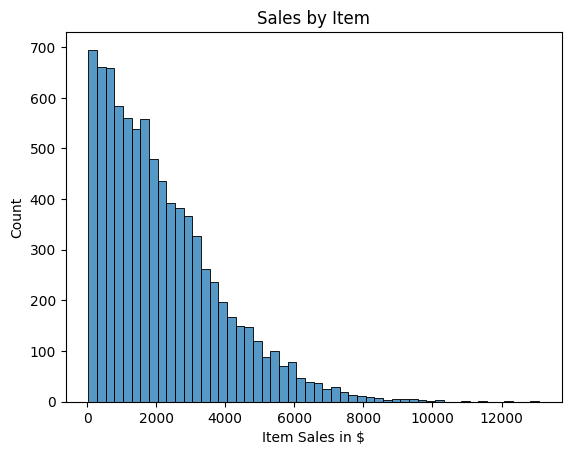

In [407]:
# Creating a histogram displaying the sales per item.
ax = sns.histplot(data = df, x = 'Item_Outlet_Sales', binwidth = 250)
ax.ticklabel_format(style = 'plain')
ax.set_title('Sales by Item');
ax.set_xlabel('Item Sales in $');

- This histogram shows that there are over 1,500 items that generate less than $500 in sales.
- We can potentially take a closer look into these items to see why that may be the case.

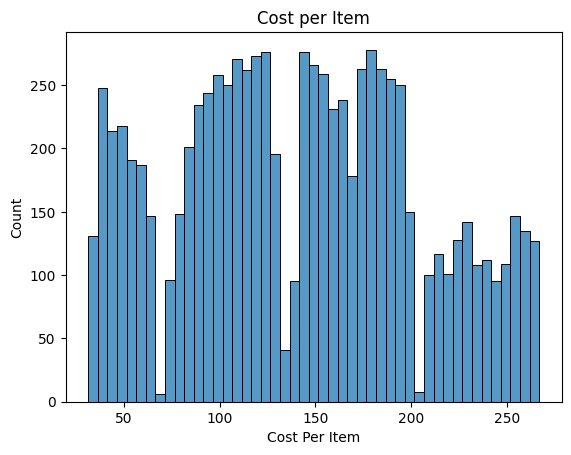

In [408]:
# Creating a histogram displaying the cost per item.
ax = sns.histplot(data = df, x = 'Item_MRP', binwidth = 5)
ax.ticklabel_format(style = 'plain')
ax.set_title('Cost per Item');
ax.set_xlabel('Cost Per Item');

#### Boxplots

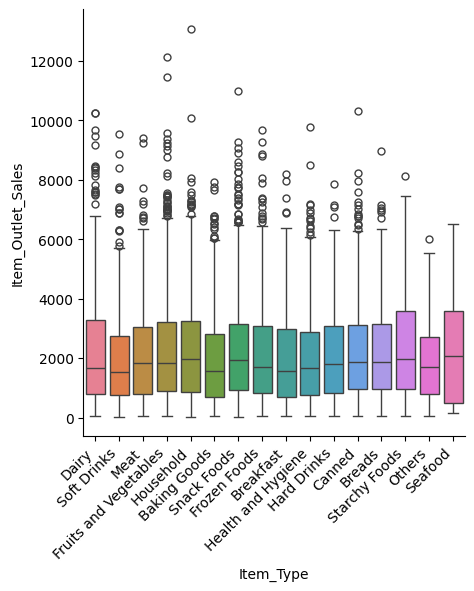

In [409]:
# Plotting a boxplot representing total sales by Item_Type
ax = sns.catplot(data = df, x = 'Item_Type', y = 'Item_Outlet_Sales',
                 hue = 'Item_Type',
                 kind = 'box', dodge = False)
ax.set_xticklabels( rotation = 45, ha = 'right');

- From first inspection it appears that Seafood is the most consistent seller. As it has the highest minimum, median value, potentially the highest 75th percentile.
- We can take a closer look into the Others and baking foods item types to see if we can find out why they may be falling behind.

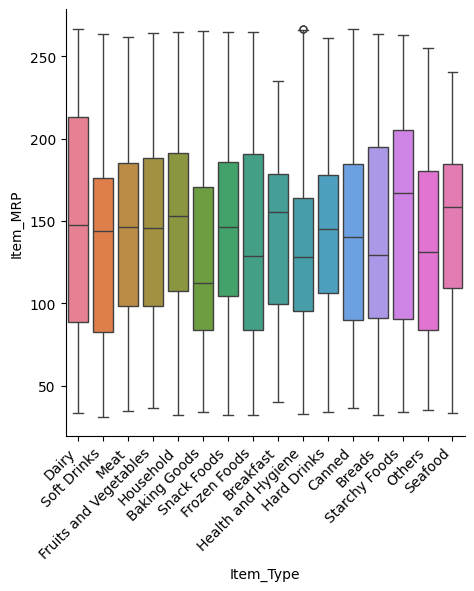

In [410]:
ax = sns.catplot(data = df, x = 'Item_Type', y = 'Item_MRP',
                 hue = 'Item_Type',
                 kind = 'box', dodge = False)
ax.set_xticklabels( rotation = 45, ha = 'right');

#### Countplots

In [411]:
item_type_counts = df['Item_Type'].value_counts()


/tmp/ipython-input-1957022067.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right');


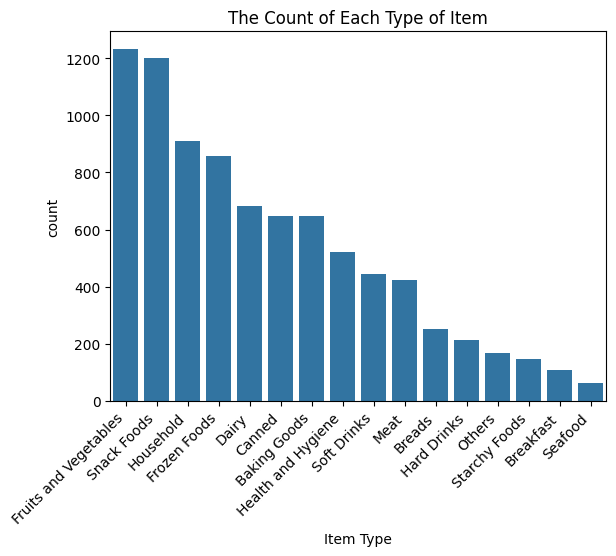

In [412]:
ax = sns.countplot(data = df, x = 'Item_Type',
                   order = item_type_counts.index)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right');
ax.set_xlabel('Item Type');
ax.set_title('The Count of Each Type of Item');

- Knowing how well seafood performs overall, we might want to look into upping the seafood inventory at certain locations.
- I would also reccomend upping the Starchy food inventory due to it's consistentcy.
- The top three item groups all perform very well.

#### Heatmaps

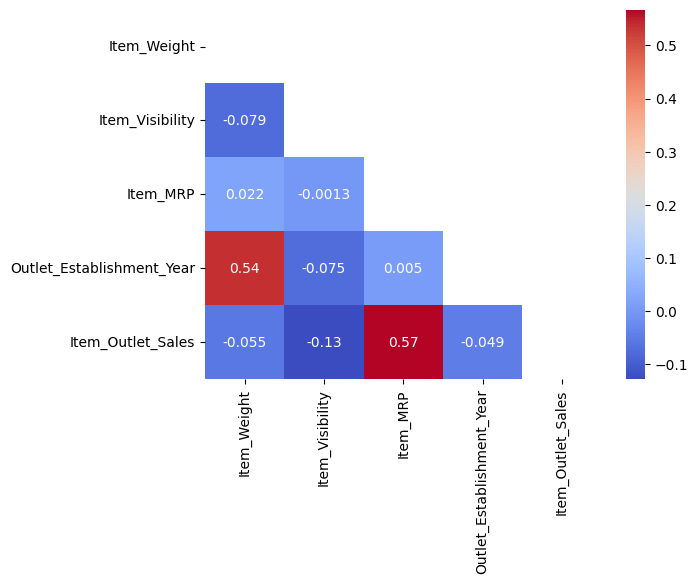

In [413]:
# Creating a variable that contains the correlations.
corr = df.corr(numeric_only = True)
# The mask variable allows us to mask half of the heatmap.
mask = np.triu(np.ones_like(corr))
# The heatmap.
sns.heatmap(corr, cmap = 'coolwarm', annot = True, mask = mask);

- There is only a moderate correlation between Item_Weight and Outlet_Establishment_Year, and Item_Outlet_Sales with Item_MRP.
- I can't imagine the correlation between between Item_Weight and Outlet_Establishment_Year means all to much but we will look further into it.

#### Visualizing correlations



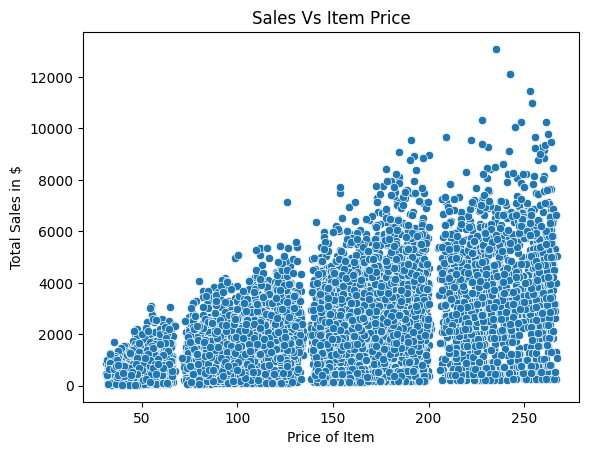

In [414]:
ax = sns.scatterplot(data = df, x = 'Item_MRP', y = 'Item_Outlet_Sales')
ax.set_title('Sales Vs Item Price');
ax.set_ylabel('Total Sales in $');
ax.set_xlabel('Price of Item');

- Visualizing the correlation found between "Item_MRP" and "Item_Outlet_Sales" appears to show that the higher the price of an item the higher the item's poetential sales.
- We might be able to leverage this by adding more high quality, high price items to our stock.

In [415]:
df.head()

,Item_Category,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FD,A15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DR,C01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FD,N15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FD,X07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NC,D19,8.93,NC,0.000000,Household,53.8614,OUT013,1987,Large,Tier 3,Supermarket Type1,994.7052


## Feature inspection

In [416]:
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold');

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")

  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100

  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax

In [417]:
def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes

In [418]:
"""MULTIVARIATE PLOTTING FUNCTIONS VS. NUMERIC TARGET"""

def plot_categorical_vs_target(df, x, y = 'Item_Outlet_Sales',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  """Plots a combination of a seaborn barplot of means combined with
  a seaborn stripplot to show the spread of the data.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  return fig, ax


def plot_numeric_vs_target(df, x, y='Item_Outlet_Sales',
                           figsize=(6,4),
                           ):
  """Plots a seaborn regplot with Pearson's correlation (r) added
  to the title.
  """
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]

  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)

  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')

  # Make sure the plot is shown before the print statement
  plt.show()

  return fig, ax

### Item_Weight

In [419]:
# Creating a filter that contains every "-1" placeholder in the Item_Weight column
filter_neg_weight = df['Item_Weight'] < 0
filter_neg_weight.sum()

np.int64(1463)

In [420]:
# Replacing negative values with null values
df.loc[filter_neg_weight,'Item_Weight'] = np.nan
# Confirming the change
filter_neg_weight = df['Item_Weight'] < 0
filter_neg_weight.sum()

np.int64(0)

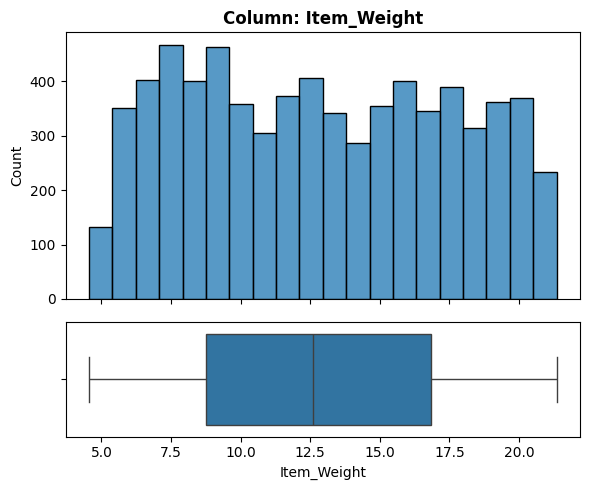

- NaN's Found: 1463 (17.17%)
- Unique Values: 415
- Most common value: 'nan' occurs 1463 times (17.17%)
- Not constant or quasi-constant.


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: Item_Weight'}, xlabel='Item_Weight', ylabel='Count'>,
        <Axes: xlabel='Item_Weight'>], dtype=object))

In [421]:
explore_numeric(df, 'Item_Weight')

- What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Item_Weight is numeric
- How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 1463 null values, 17.17 percent of all values.
  - I'd impute with the mean weight.
- Is the feature constant or quasi-constant?
  - Item_Weight is not quasi-constant.
- What is the cardinality? Is it high (>10)?
  - Item_Weight has a very large cardinality.
- Would we know this feature before the target is determined?
  - Yes.
- Is there a business case/understanding reason to exclude based on our business case?
  - No, the weight of the item is important. Even if we don't have all the data knowing whether or not heavy items do well could help on shipping costs.

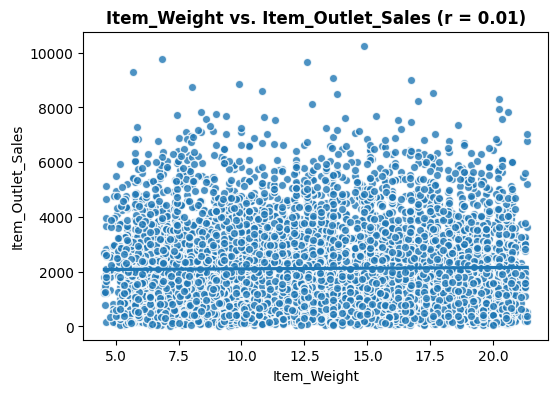

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Item_Weight vs. Item_Outlet_Sales (r = 0.01)'}, xlabel='Item_Weight', ylabel='Item_Outlet_Sales'>)

In [422]:
plot_numeric_vs_target(df, 'Item_Weight')

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - I wouldn't assume the weight of an item has much to do with it's sales.
- Does this feature appear to be a predictor of the target?
  - No, There seems to be little or no correlation with our target.

### Outlet_Size

In [477]:
# Creating an order in which the data is displayed.
uni_order = {'Medium', 'Large', 'Small'}

/tmp/ipython-input-350550033.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


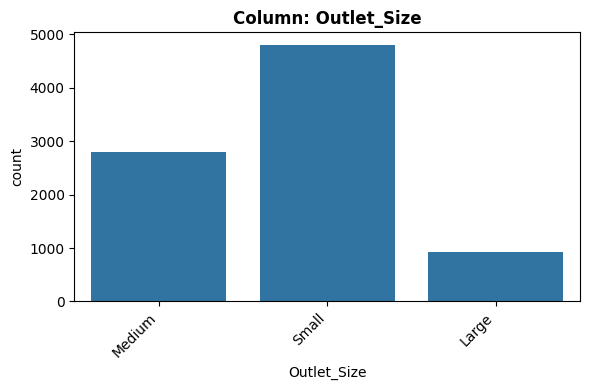

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'Small' occurs 4798 times (56.29%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Outlet_Size'}, xlabel='Outlet_Size', ylabel='count'>)

In [426]:
explore_categorical(df , 'Outlet_Size')

- What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This is a ordinal feature
- How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are no null values.
  - We can use machine learning to look into the statistics of each missing store size and infer what the size may be.
- Is the feature constant or quasi-constant?
  - It is neither constant or quasi-constant
- What is the cardinality? Is it high (>10)?
  - The cardinality is not high, being only 4.
- Would we know this feature before the target is determined?
  - Yes
- Is there a business case/understanding reason to exclude based on our business case?
  - No, the size of the outlet is important information.

In [478]:
# Creating an order in which the data is displayed.
multi_order = {'Large', 'Medium', 'Small'}

/tmp/ipython-input-4191817704.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet_Size vs. Item_Outlet_Sales'}, xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>)

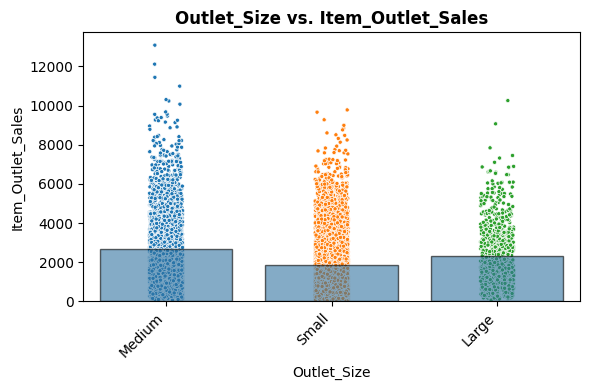

In [428]:
plot_categorical_vs_target(df, 'Outlet_Size')

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - Yes, I would expect the outlet size to impact sales in one way or another.
- Does this feature appear to be a predictor of the target?
  - This feature seems to reveal that medium outlets are performing better than both large and small outlets. This could mean it's more worth it to invest in a medium sized outlet over a large outlet.

### Item_Category

/tmp/ipython-input-350550033.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


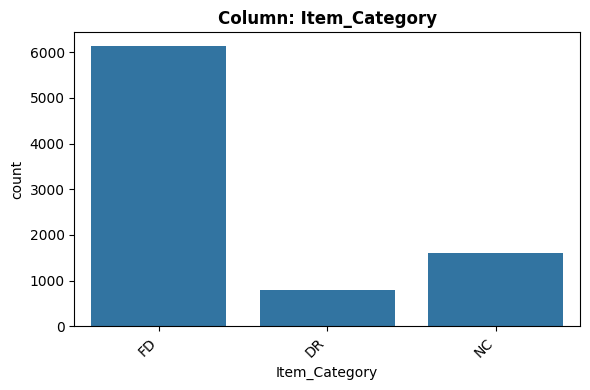

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'FD' occurs 6125 times (71.86%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Item_Category'}, xlabel='Item_Category', ylabel='count'>)

In [429]:
explore_categorical(df, 'Item_Category')

- What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Item_Category is ordinal.
- How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are no null values.
Is the feature constant or quasi-constant?
- What is the cardinality? Is it high (>10)?
  - The cardinality is low, being only 3.
- Would we know this feature before the target is determined?
  - Yes.
- Is there a business case/understanding reason to exclude based on our business case?
  - No.

/tmp/ipython-input-4191817704.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Item_Category vs. Item_Outlet_Sales'}, xlabel='Item_Category', ylabel='Item_Outlet_Sales'>)

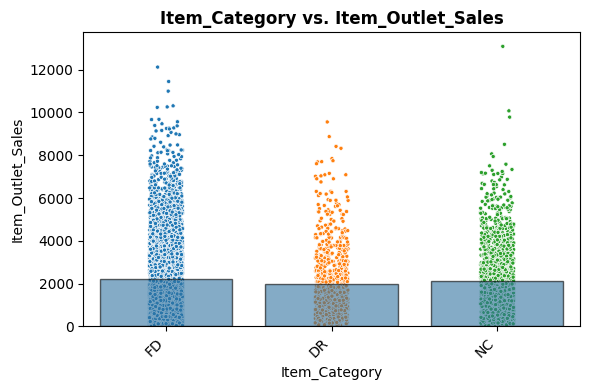

In [430]:
plot_categorical_vs_target(df, 'Item_Category')

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - Yes, item category could absolutely play a significant role in predicting overall sales.
- Does this feature appear to be a predictor of the target?
  - Item category does not appear to be a predictor of the target in this scenario.

### Item_Identifier

/tmp/ipython-input-350550033.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


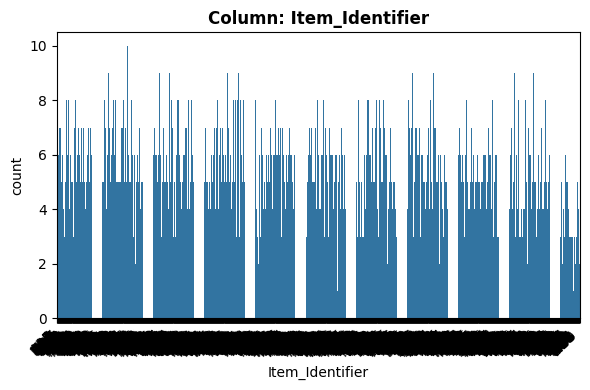

- NaN's Found: 0 (0.0%)
- Unique Values: 1559
- Most common value: 'W13' occurs 10 times (0.12%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Item_Identifier'}, xlabel='Item_Identifier', ylabel='count'>)

In [431]:
explore_categorical(df, 'Item_Identifier')

- What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Item_Identifier is categorical.
- How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are no null values.
- Is the feature constant or quasi-constant?
  - No.
- What is the cardinality? Is it high (>10)?
  - The cardinality is, much too high to be useful.
- Would we know this feature before the target is determined?
  - Yes.
- Is there a business case/understanding reason to exclude based on our business case?
  - Yes. The cardinality is way too high, it would be better to look at the Item_Category instead.

/tmp/ipython-input-4191817704.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Item_Identifier vs. Item_Outlet_Sales'}, xlabel='Item_Identifier', ylabel='Item_Outlet_Sales'>)

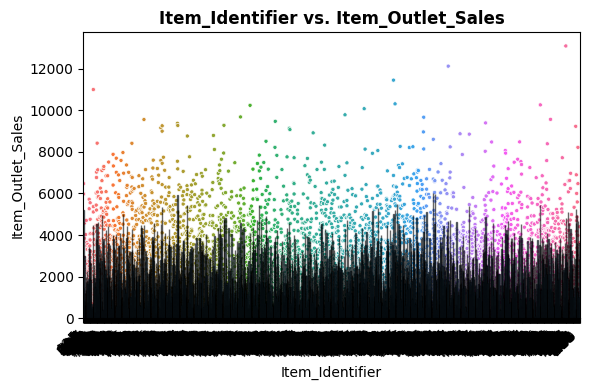

In [432]:
plot_categorical_vs_target(df, 'Item_Identifier')

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - No, as the number given is just an identifier
- Does this feature appear to be a predictor of the target?
  - No, the plot is not readable.

###Item_Fat_Content

/tmp/ipython-input-350550033.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


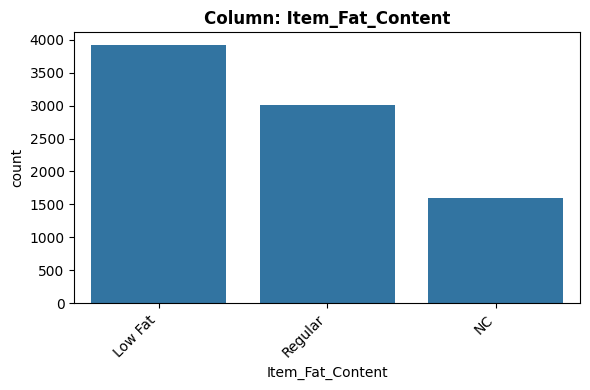

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'Low Fat' occurs 3918 times (45.97%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Item_Fat_Content'}, xlabel='Item_Fat_Content', ylabel='count'>)

In [433]:
explore_categorical(df, 'Item_Fat_Content')

- What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Item_Fat_Content is ordinal.
- How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are no null values.
- Is the feature constant or quasi-constant?
  - Item_Fat_Content is not constant or quasi-constant.
- What is the cardinality? Is it high (>10)?
  - The cardinality is low, being only 2.
- Would we know this feature before the target is determined?
  - Yes,
- Is there a business case/understanding reason to exclude based on our business case?
  - No.

/tmp/ipython-input-4191817704.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Item_Fat_Content vs. Item_Outlet_Sales'}, xlabel='Item_Fat_Content', ylabel='Item_Outlet_Sales'>)

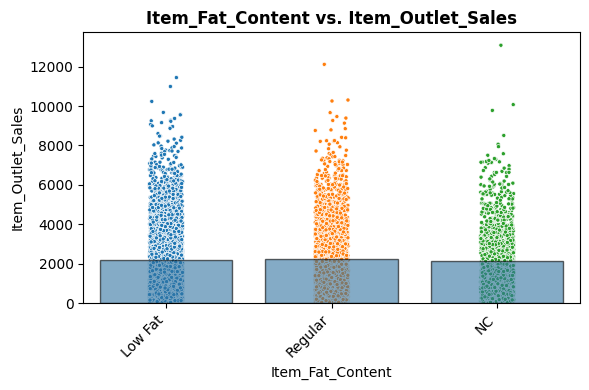

In [434]:
plot_categorical_vs_target(df, 'Item_Fat_Content')

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - I could see this feature playing a small part potentially.
- Does this feature appear to be a predictor of the target?
  - Item_Fat_Content does not appear to be a predictor of sales.

### Item_Visibility

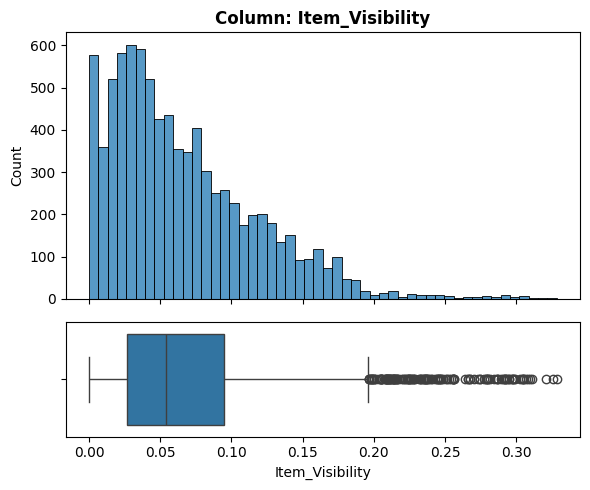

- NaN's Found: 0 (0.0%)
- Unique Values: 7880
- Most common value: '0.0' occurs 526 times (6.17%)
- Not constant or quasi-constant.


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: Item_Visibility'}, xlabel='Item_Visibility', ylabel='Count'>,
        <Axes: xlabel='Item_Visibility'>], dtype=object))

In [435]:
explore_numeric(df, 'Item_Visibility')

- What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Item_Visibility is numeric.
- How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are no null values.
- Is the feature constant or quasi-constant?
  - The feature is neither constant or quasi-constant
- What is the cardinality? Is it high (>10)?
  - The cardinality is high.
- Would we know this feature before the target is determined?
  - Yes.
- Is there a business case/understanding reason to exclude based on our business case?
  - No.

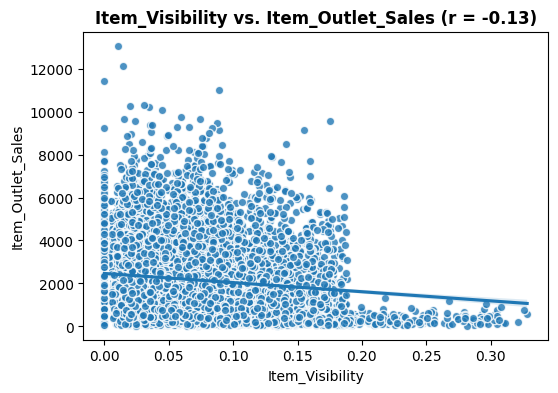

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Item_Visibility vs. Item_Outlet_Sales (r = -0.13)'}, xlabel='Item_Visibility', ylabel='Item_Outlet_Sales'>)

In [436]:
plot_numeric_vs_target(df, 'Item_Visibility')

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - I would assume that higher visibility would return higher sales.
- Does this feature appear to be a predictor of the target?
  - This feature does appear to be a predictor of sales. However, Visibility seems to negatively impact sales.

### Item_Type

/tmp/ipython-input-350550033.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


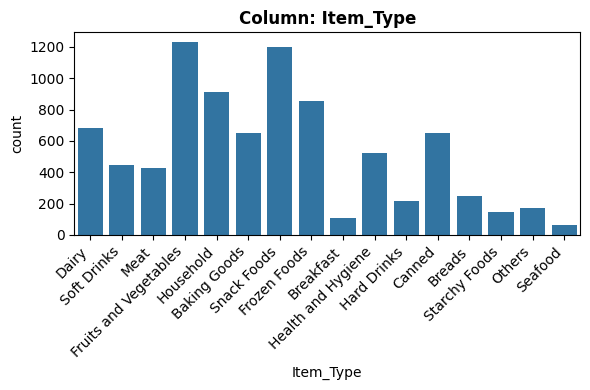

- NaN's Found: 0 (0.0%)
- Unique Values: 16
- Most common value: 'Fruits and Vegetables' occurs 1232 times (14.46%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Item_Type'}, xlabel='Item_Type', ylabel='count'>)

In [437]:
explore_categorical(df, 'Item_Type')

- What type of feature is it?
  - Item_Type is categorical.
- How many null values? What percentage? What would you do with the null values
  - There are no null values.
- Is the feature constant or quasi-constant?
  - The Feature is not constant or quasi-constant.
- What is the cardinality? Is it high?
  - The cardinality is high, 16 unique inputs.
- Would we know this feature before the target is determined?
  - Yes.
- Is there a business case/understanding reason to exclude based on our business case?
  No.

/tmp/ipython-input-4191817704.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Item_Type vs. Item_Outlet_Sales'}, xlabel='Item_Type', ylabel='Item_Outlet_Sales'>)

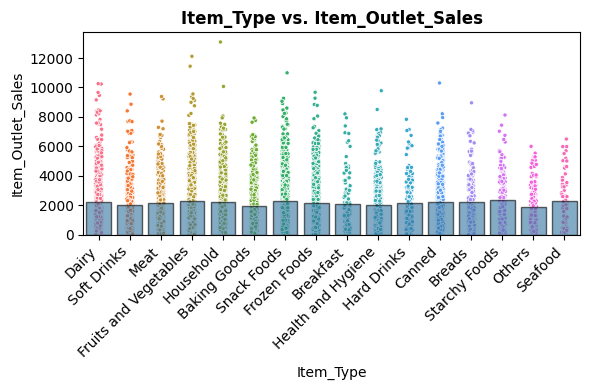

In [438]:
plot_categorical_vs_target(df, 'Item_Type')

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - Yes, I'd assume the item type would impact sales.
- Does this feature appear to be a predictor of the target?
  - Item_Type could be a weak predictor of sales.

### Item_MRP

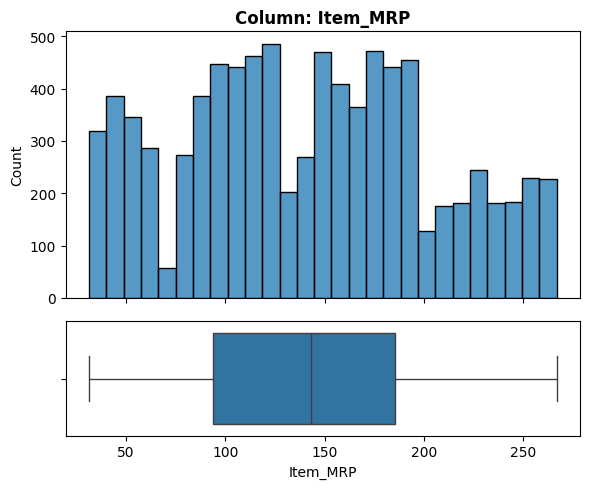

- NaN's Found: 0 (0.0%)
- Unique Values: 5938
- Most common value: '172.0422' occurs 7 times (0.08%)
- Not constant or quasi-constant.


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: Item_MRP'}, xlabel='Item_MRP', ylabel='Count'>,
        <Axes: xlabel='Item_MRP'>], dtype=object))

In [439]:
explore_numeric(df, 'Item_MRP')

- What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Item_MRP is numeric.
- How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are no null values.
- Is the feature constant or quasi-constant?
  - Neither constant or quasi-constant.
- What is the cardinality? Is it high (>10)?
  - The caridnality is very high.
- Would we know this feature before the target is determined?
  - Yes.
- Is there a business case/understanding reason to exclude based on our business case?
  - No.

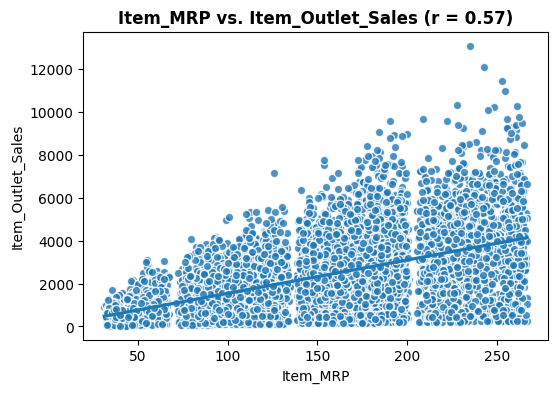

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Item_MRP vs. Item_Outlet_Sales (r = 0.57)'}, xlabel='Item_MRP', ylabel='Item_Outlet_Sales'>)

In [440]:
plot_numeric_vs_target(df, 'Item_MRP')

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - Yes, I would asusme the cost of an item would impact it's sales.
- Does this feature appear to be a predictor of the target?
  - Item_MRP appear to be positively correlated with item sales.

### Outlet_Identifier

/tmp/ipython-input-350550033.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


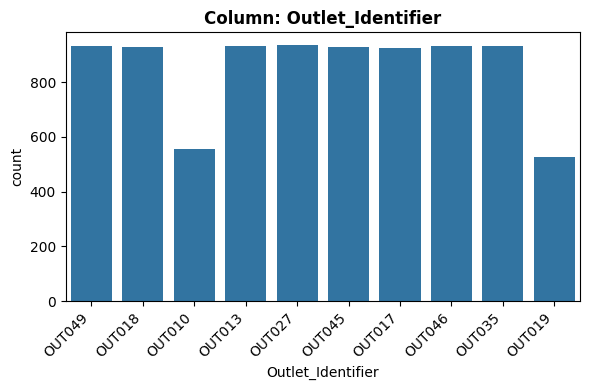

- NaN's Found: 0 (0.0%)
- Unique Values: 10
- Most common value: 'OUT027' occurs 935 times (10.97%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Outlet_Identifier'}, xlabel='Outlet_Identifier', ylabel='count'>)

In [441]:
explore_categorical(df, 'Outlet_Identifier')

- What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Outlet_Identifier is ordinal.
- How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are no null valeus.
- Is the feature constant or quasi-constant?
  - The feature isn't constant or quasi-constant.
- What is the cardinality? Is it high (>10)?
  - The caridnality is moderately high, being 10.
- Would we know this feature before the target is determined?
  - Yes.
- Is there a business case/understanding reason to exclude based on our business case?
  - No.

/tmp/ipython-input-4191817704.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet_Identifier vs. Item_Outlet_Sales'}, xlabel='Outlet_Identifier', ylabel='Item_Outlet_Sales'>)

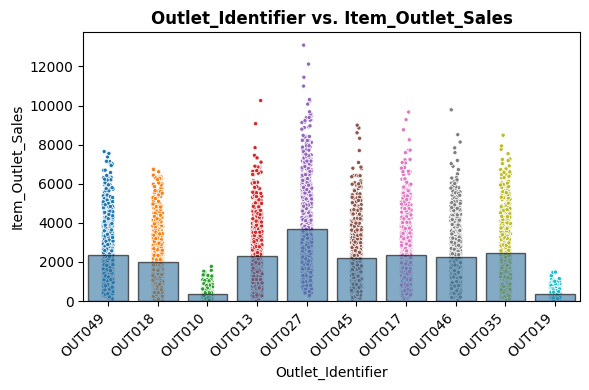

In [442]:
plot_categorical_vs_target(df, 'Outlet_Identifier')

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - I would assume looking at individual stores would give extra insight to item sales.
- Does this feature appear to be a predictor of the target?
  - Outlet_Identifier appears to be a predictor of item sales.

### Outlet_Establishment_Year

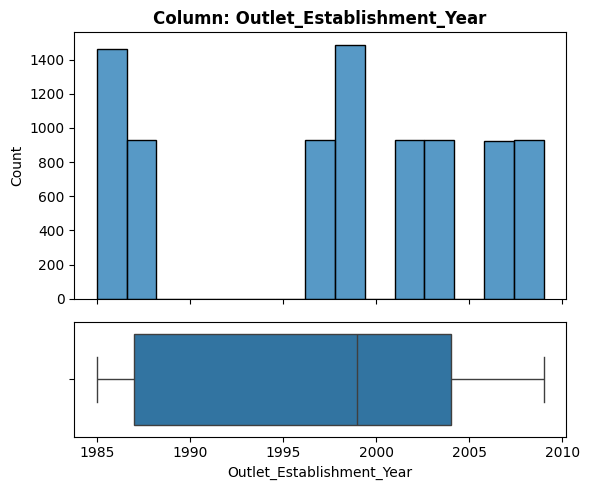

- NaN's Found: 0 (0.0%)
- Unique Values: 9
- Most common value: '1985' occurs 1463 times (17.17%)
- Not constant or quasi-constant.


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: Outlet_Establishment_Year'}, xlabel='Outlet_Establishment_Year', ylabel='Count'>,
        <Axes: xlabel='Outlet_Establishment_Year'>], dtype=object))

In [443]:
explore_numeric(df, 'Outlet_Establishment_Year')

- What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Item_Establishment_Year is numeric.
- How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are no null values.
- Is the feature constant or quasi-constant?
  - Outlet_Establishment_Year is not constant or quasi constant.
- What is the cardinality? Is it high (>10)?
  - The cardinality is moderately high at 9.
- Would we know this feature before the target is determined?
  - Yes.
- Is there a business case/understanding reason to exclude based on our business case?
  - No.

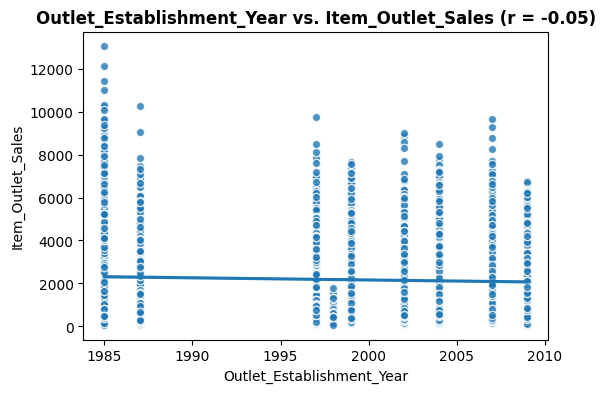

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet_Establishment_Year vs. Item_Outlet_Sales (r = -0.05)'}, xlabel='Outlet_Establishment_Year', ylabel='Item_Outlet_Sales'>)

In [444]:
plot_numeric_vs_target(df, 'Outlet_Establishment_Year')

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - I wouldn't assume the establishment year would have much to do with sales.
- Does this feature appear to be a predictor of the target?
  - Although it may seem that establishment year has some correlation with sales, it's most likely due to the size of the store opened.

### Outlet_Type

/tmp/ipython-input-350550033.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


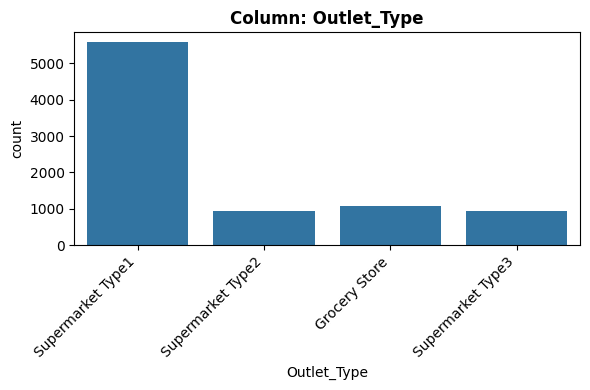

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'Supermarket Type1' occurs 5577 times (65.43%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: Outlet_Type'}, xlabel='Outlet_Type', ylabel='count'>)

In [445]:
explore_categorical(df, 'Outlet_Type')

- What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Outlet_Type is ordinal.
- How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are no null  values.
- Is the feature constant or quasi-constant?
  - No.
- What is the cardinality? Is it high (>10)?
  - The cardinality is fairly low at only 4.
- Would we know this feature before the target is determined?
  - Yes.
- Is there a business case/understanding reason to exclude based on our business case?
  - No.

/tmp/ipython-input-4191817704.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet_Type vs. Item_Outlet_Sales'}, xlabel='Outlet_Type', ylabel='Item_Outlet_Sales'>)

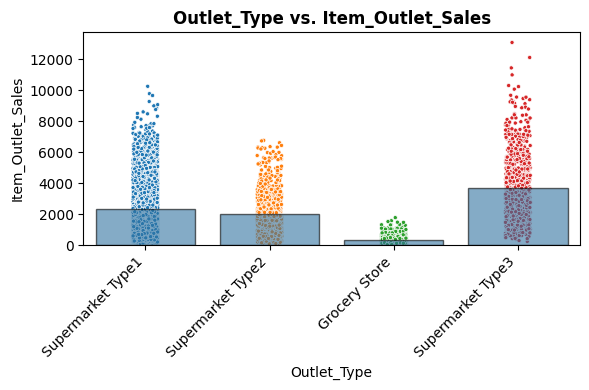

In [446]:
plot_categorical_vs_target(df, 'Outlet_Type')

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - Yes, I would think that outlet type would be one of the largest indicators of sales.
- Does this feature appear to be a predictor of the target?
  - Yes. Outlet_Type does seem to be a predictor of sales.

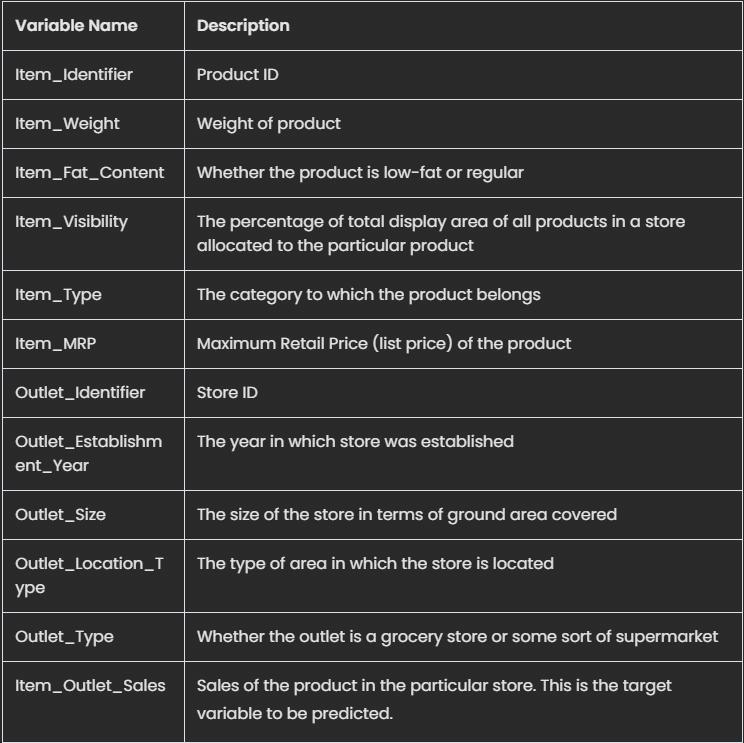

# Machine Learning preparation

## Loading and data inspection

In [447]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)
import missingno
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

In [448]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [449]:
fpath = '/content/drive/MyDrive/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv'
df2 = pd.read_csv(fpath)

In [450]:
df2.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [451]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [452]:
df2.dtypes

,0
Item_Identifier,object
Item_Weight,float64
Item_Fat_Content,object
Item_Visibility,float64
Item_Type,object
Item_MRP,float64
Outlet_Identifier,object
Outlet_Establishment_Year,int64
Outlet_Size,object
Outlet_Location_Type,object


## Cleaning Data for Machine Learning

### Duplicated Data

In [453]:
# Creating a filter that identifies duplicated rows.
duplicated_rows = df2.duplicated()
# finding the sum of duplicated rows.
duplicated_rows.sum()

np.int64(0)

- There are no duplicated rows.

### Data Inconsistencies

#### Categorical inconsistencies

In [454]:
# Saving a list of object columns
string_cols = df2.select_dtypes('object').columns
string_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [455]:
# Checking the number of unique values in each object column.
df2[string_cols].nunique()

,0
Item_Identifier,1559
Item_Fat_Content,5
Item_Type,16
Outlet_Identifier,10
Outlet_Size,3
Outlet_Location_Type,3
Outlet_Type,4


In [456]:
# Checking the percentage of unique values to ensure nothing is too our of the ordinary
df2[string_cols].nunique() / len(df) * 100

,0
Item_Identifier,18.291681
Item_Fat_Content,0.058665
Item_Type,0.187727
Outlet_Identifier,0.117330
Outlet_Size,0.035199
Outlet_Location_Type,0.035199
Outlet_Type,0.046932


In [457]:
# loop through the list of string columns
for col in string_cols:
  # print the value counts for the column
  print(f'Value counts for {col}')
  print(df2[col].value_counts())
  # Printing an empty line for readability
  print('\n')

Value counts for Item_Identifier
Item_Identifier
FDW13    10
FDG33    10
FDX31     9
FDT07     9
NCY18     9
         ..
FDO33     1
FDK57     1
FDT35     1
FDN52     1
FDE52     1
Name: count, Length: 1559, dtype: int64


Value counts for Item_Fat_Content
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64


Value counts for Item_Type
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64


Value counts for Outlet_Identifier
Outlet_Identifier
OUT027    935
OUT013

- Using this method we can see a there are a few inconsistencies in Item_Fat_Content. Where Low fat, LF, low fat, reg, Regular can be simplified
- Along with weird phrasing in Outlet_Size where it goes from Small, Medium, and High.

In [458]:
# Replacing "LF" and "low fat" with "Low Fat" in Item_Fat_Content.
df2['Item_Fat_Content'] = df2['Item_Fat_Content'].replace({'LF': 'Low Fat',
                                                         'low fat': 'Low Fat'})
df2['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5517
Regular,2889
reg,117


In [459]:
# Replacing "reg" with "Regular".
df2['Item_Fat_Content'] = df2['Item_Fat_Content'].replace({'reg': 'Regular'})
# Ensuring that the oddities are resovled
df2['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5517
Regular,3006


In [460]:
# Replacing "High" with "Large" in Outlet_Size for sizing terminology consistency
df2['Outlet_Size'] = df2['Outlet_Size'].replace({'High': 'Large'})
# Ensuring that the oddities are resovled
df2['Outlet_Size'].value_counts()

,count
Outlet_Size,
Medium,2793
Small,2388
Large,932


- Now all inconsistencies in Item_Fat_Content are resolved.
- While there were no clear oddities in Outlet_Size and the "fix" was largely preferential, that column is also resolved.

- The "Item_Identifier" column can be split into two separate columns. One for Item category: FD, DR, or NC and the other for Item Identifier.

In [461]:
# Splitting the "Item_Identifier" column into two separate columns
df2['Item_Category'] = df2['Item_Identifier'].str[0:2]
df2['Item_Identifier'] = df2['Item_Identifier'].str[2:]

In [462]:
# Moving the two new columns to the fron of the dataframe
# assigning the column to move to a varaible
col_to_move = df2.pop('Item_Category')

# Inserting column into the second position
df2.insert(0, 'Item_Category', col_to_move)

- Now that the column has bee split, I can change all NC (non-consumable) items from low-fat to NC.

In [463]:
# Changing all NC categorized items from low fat to NC.
df2['Item_Fat_Content'] = df2['Item_Fat_Content'].where(df2['Item_Category'] != 'NC',
                            df2['Item_Fat_Content'].replace({'Low Fat': 'NC'}))

In [464]:
df2.head()

,Item_Category,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FD,A15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DR,C01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FD,N15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FD,X07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NC,D19,8.93,NC,0.000000,Household,53.8614,OUT013,1987,Large,Tier 3,Supermarket Type1,994.7052


#### Numerical Inconsistencies

In [465]:
# Saving a list of numerical columns
num_cols = df2.select_dtypes('number').columns
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [466]:
# Using .describe() to view the statistics of our data
for col in num_cols:
  # print the description of each column
  print(f'Value counts for {col}')
  print(df2[col].describe())
  # Print an empty line for readability
  print('\n')

Value counts for Item_Weight
count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64


Value counts for Item_Visibility
count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64


Value counts for Item_MRP
count    8523.000000
mean      140.992782
std        62.275067
min        31.290000
25%        93.826500
50%       143.012800
75%       185.643700
max       266.888400
Name: Item_MRP, dtype: float64


Value counts for Outlet_Establishment_Year
count    8523.000000
mean     1997.831867
std         8.371760
min      1985.000000
25%      1987.000000
50%      1999.000000
75%      2004.000000
max      2009.000000
Name: Outlet_Establishment_Year, dtype: float64


Value counts for Item_Outlet_Sales
cou

### Dropping columns with a large cardinality

- The "Item_Identifier" has a very large cardinality. This will create a lot of noise when it comes to machine learning. So we'll drop the column.

In [467]:
df2 = df2.drop(columns = 'Item_Identifier')
df2.head()

,Item_Category,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FD,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DR,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FD,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FD,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NC,8.93,NC,0.000000,Household,53.8614,OUT013,1987,Large,Tier 3,Supermarket Type1,994.7052


## Creating the the training and test splits

In [468]:
# Defining the target as Item_Outlet_Sales
target = df2['Item_Outlet_Sales']
# Defining y as our target
y = target
# Defining X as all relevant features in predicting our target
X = df2.drop(columns = 'Item_Outlet_Sales')

In [469]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## Preparing numeric values for ColumnTransformer

### Numeric Pipeline

In [470]:
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
num_pipe

Numeric Columns: Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

### Numeric Tuple

In [471]:
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
        'Outlet_Establishment_Year'],
       dtype='object'))

## Preparing Oridnal values for ColumnTransformer

### Ordinal Pipeline

In [472]:
# Save list of column names
ord_cols = ['Outlet_Size']
print("Ordinal Columns:", ord_cols)
# Create imputer for ordinal data
impute_most_freq = SimpleImputer(strategy = 'most_frequent')
## Making the OrdinalEncoder
# Specifying order of categories for our  Ordinal Qual/Cond Columms
outlet_size_order = ['Small', 'Medium', 'Large']
# Making the list of order lists for OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories = [outlet_size_order])
# Making a final scaler to scale category #'s
scaler_ord = StandardScaler()
## Making an ord_pipe
ord_pipe = make_pipeline(impute_most_freq, ordinal_encoder, scaler)
ord_pipe

Ordinal Columns: ['Outlet_Size']


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Small', 'Medium', 'Large']])),
                ('standardscaler', StandardScaler())])

### Ordinal Tuple

In [473]:
# Making an ordinal_tuple for ColumnTransformer
ord_tuple = ('ordinal', ord_pipe, ord_cols)
ord_tuple

('ordinal',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Small', 'Medium', 'Large']])),
                 ('standardscaler', StandardScaler())]),
 ['Outlet_Size'])

## Preparing Categorical values for ColumnTransformer

### Categorical Pipeline

In [488]:
# Save list of column names
ohe_cols = X_train.select_dtypes('object').drop(columns = ord_cols).columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy = 'constant', fill_value = "MISSING",
                         )
ohe_encoder = OneHotEncoder(drop = 'first', sparse_output = False)
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_pipe

OneHotEncoder Columns: Index(['Item_Category', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(drop='first', sparse_output=False))])

### Categorical Tuple

In [487]:
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
ohe_tuple

('categorical',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='MISSING', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(drop='first', sparse_output=False))]),
 Index(['Item_Category', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
        'Outlet_Location_Type', 'Outlet_Type'],
       dtype='object'))

## Instantiating and Fitting the ColumnTransformer

In [489]:
# Instantiate with verbose_feature_names_out=False
col_transformer = ColumnTransformer([num_tuple, ohe_tuple, ord_tuple],
                                    verbose_feature_names_out=False)
# Fit on training data
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 (...
                                 Index(['Item_Category', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'Large']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size'])],
                  verbose_feature_names_out=False)

## Transforming the training and test data

In [490]:
# Transform the training data
X_train_processed = col_transformer.transform(X_train)
# Transform the testing data
X_test_processed = col_transformer.transform(X_test)
# run get_feature_names_out
feature_names = col_transformer.get_feature_names_out()
X_train_tf = pd.DataFrame(col_transformer.transform(X_train),
                          columns = feature_names, index = X_train.index)

X_test_tf = pd.DataFrame(col_transformer.transform(X_test),
                          columns = feature_names, index = X_test.index)
X_test_tf.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Category_FD,Item_Category_NC,Item_Fat_Content_NC,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size
7503,0.341372,-0.776646,-0.998816,-1.293807,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.958796
2957,-1.169135,0.100317,-1.585194,-0.102145,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.384048
7031,0.388798,-0.482994,-1.595784,0.136187,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.287374


### Checking the data in the transformed data

In [491]:
# Viewing the processed training data
X_train_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Category_FD,Item_Category_NC,Item_Fat_Content_NC,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size
4776,0.827485,-0.712775,1.828109,1.327849,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.287374
7510,0.566644,-1.291052,0.603369,1.327849,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.287374
5828,-0.121028,1.813319,0.244541,0.136187,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.287374
5327,-1.158464,-1.004931,-0.952591,0.732018,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.384048
4810,1.538870,-0.965484,-0.336460,0.493686,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.287374


In [492]:
# Viewing the processed testing data
X_test_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Category_FD,Item_Category_NC,Item_Fat_Content_NC,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size
7503,0.341372,-0.776646,-0.998816,-1.293807,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.958796
2957,-1.169135,0.100317,-1.585194,-0.102145,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.384048
7031,0.388798,-0.482994,-1.595784,0.136187,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.287374
1084,-0.049889,-0.415440,0.506592,-1.532139,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.287374
856,-0.632039,-1.047426,0.886725,0.732018,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.384048


### Verifying everything was scaled properly

In [493]:
# Verifying all the data types
X_train_processed.dtypes

,0
Item_Weight,float64
Item_Visibility,float64
Item_MRP,float64
Outlet_Establishment_Year,float64
Item_Category_FD,float64
Item_Category_NC,float64
Item_Fat_Content_NC,float64
Item_Fat_Content_Regular,float64
Item_Type_Breads,float64
Item_Type_Breakfast,float64


In [494]:
# Verfiying all data has been scaled
X_train_processed.describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Category_FD,Item_Category_NC,Item_Fat_Content_NC,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size
count,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.0,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00
mean,-0.00,-0.00,0.00,-0.00,0.72,0.19,0.19,0.35,0.03,0.01,0.08,0.08,0.1,0.15,0.03,0.06,0.11,0.05,0.02,0.01,0.14,0.05,0.02,0.11,0.11,0.11,0.06,0.11,0.11,0.11,0.11,0.11,0.33,0.40,0.65,0.11,0.11,0.00
std,1.00,1.00,1.00,1.00,0.45,0.39,0.39,0.48,0.16,0.11,0.26,0.27,0.3,0.36,0.16,0.24,0.31,0.21,0.14,0.08,0.35,0.22,0.14,0.31,0.31,0.31,0.24,0.32,0.31,0.31,0.31,0.31,0.47,0.49,0.48,0.31,0.32,1.00
min,-1.97,-1.29,-1.77,-1.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.38
25%,-0.80,-0.76,-0.76,-1.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.38
50%,-0.05,-0.23,0.03,0.14,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.29
75%,0.77,0.56,0.72,0.73,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.29
max,2.01,5.13,1.99,1.33,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.96


- every data type is float64 numeric data type.
- The means and standard deviations are both zero and one respectively.
- I can confidently say the training data was scaled properly

In [495]:
# Verifying all the data types
X_test_processed.dtypes

,0
Item_Weight,float64
Item_Visibility,float64
Item_MRP,float64
Outlet_Establishment_Year,float64
Item_Category_FD,float64
Item_Category_NC,float64
Item_Fat_Content_NC,float64
Item_Fat_Content_Regular,float64
Item_Type_Breads,float64
Item_Type_Breakfast,float64


In [496]:
# Verfiying all data has been scaled
X_test_processed.describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Category_FD,Item_Category_NC,Item_Fat_Content_NC,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size
count,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.0,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.0,2131.0,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.0,2131.00
mean,-0.04,0.01,-0.06,-0.01,0.73,0.18,0.18,0.35,0.04,0.01,0.08,0.08,0.11,0.13,0.02,0.06,0.1,0.06,0.02,0.01,0.14,0.05,0.01,0.11,0.11,0.11,0.07,0.1,0.1,0.11,0.11,0.12,0.32,0.38,0.66,0.11,0.1,0.01
std,1.01,1.04,0.98,0.99,0.45,0.38,0.38,0.48,0.19,0.11,0.27,0.27,0.31,0.34,0.14,0.24,0.3,0.23,0.13,0.10,0.34,0.23,0.11,0.32,0.31,0.31,0.25,0.3,0.3,0.31,0.31,0.32,0.47,0.49,0.47,0.31,0.3,1.01
min,-1.96,-1.29,-1.75,-1.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,-1.38
25%,-0.88,-0.76,-0.78,-1.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,-1.38
50%,-0.05,-0.24,-0.15,0.14,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.0,0.29
75%,0.74,0.56,0.64,0.73,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.0,0.29
max,2.01,4.79,1.99,1.33,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.96


- every data type is float64 numeric data type.
- The means and standard deviations are both nearly zero and one respectively.
- I can confidently say the testing data was scaled properly

## CRISP-DM Phase 4 - Modeling

### Functions for Modeling

In [497]:
## SK Learn Display
set_config(display='diagram')

## Transformers output as a Pandas Dataframe
set_config(transform_output='pandas')

In [498]:
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

In [499]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics
## Create a function to take the true and predicted values
## and print MAE, MSE, RMSE, and R2 metrics
def evaluate_regression(pipe, X_train, y_train, X_test, y_test,
                       model_name='Regression Model'):

  """Takes a regression model, training features and target and testing features and target.
  Returns a dataframe of regression metrics"""

  ## Predictions
  train_pred = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  metrics = ['train_MAE','test_MAE',
             'train_RMSE', 'test_RMSE',
             'train_R2', 'test_R2']

  ## Train
  train_mae = round(mean_absolute_error(y_train, train_pred),4)
  train_rmse = round(np.sqrt(mean_squared_error(y_train, train_pred)),4)
  train_r2 = round(r2_score(y_train, train_pred),4)

  ## Test
  test_mae = round(mean_absolute_error(y_test, test_preds),4)
  test_rmse = round(np.sqrt(mean_squared_error(y_test, test_preds)),4)
  test_r2 = round(r2_score(y_test, test_preds),4)

  ## Output Dataframe
  scores = pd.DataFrame(columns=metrics, index=[model_name])
  scores.loc[model_name, :] = [train_mae, test_mae,
                              train_rmse, test_rmse,
                              train_r2, test_r2]

  return scores

In [500]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False,
                annotate=False, ha='left',va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    """Plots the top_n coefficients from a Series, with optional annotations."""
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient',
           ylabel='Feature Names',
           title=title)
    ax.axvline(0, color='k')

    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    ## return ax in case want to continue to update/modify figure
    return ax

def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:

        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

1. Your first task is to build a linear regression model to predict sales.

- Build a linear regression model.
- Use the custom evaluation function to get the metrics for your model (on training and test data).
- Compare the training vs. test R-squared values and answer the question: to what extent is this model overfit/underfit?

### Linear Regression Model

In [501]:
# Fit the model on the training data
lin_reg = LinearRegression()
lin_reg.fit(X_train_processed, y_train)

LinearRegression()

In [502]:
# Get predictions for the training data
y_predictions_train = lin_reg.predict(X_train_processed)
# Get predictions for the testing data
y_predictions_test = lin_reg.predict(X_test_processed)

In [503]:
lin_reg_scores = evaluate_regression(lin_reg, X_train_processed, y_train, X_test_processed,
                    y_test, model_name='Linear Regression')
lin_reg_scores

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Linear Regression,847.12,804.10,"1,139.10","1,092.85",0.56,0.57


- While the R^2 values are within a percent of one another, the values are only .56.
- The model appears to be underfit due to the very low variance and the high bias in the model.

### Visualizing Coefficients

In [504]:
# Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
coeffs['intercept'] = lin_reg.intercept_
coeffs

,0
Item_Weight,-8.19
Item_Visibility,-21.61
Item_MRP,984.56
Outlet_Establishment_Year,-211.81
Item_Category_FD,-6.77
Item_Category_NC,-2.04
Item_Fat_Content_NC,-2.04
Item_Fat_Content_Regular,62.85
Item_Type_Breads,-28.64
Item_Type_Breakfast,45.30


- I tried many many things and couldn't figure out how to fix the categorical columns.
- Even the oridnal columns aren't becoming coefficients correctly.


In [505]:
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
coeffs

,0
Item_Weight,-8.19
Item_Visibility,-21.61
Item_MRP,984.56
Outlet_Establishment_Year,-211.81
Item_Category_FD,-6.77
Item_Category_NC,-2.04
Item_Fat_Content_NC,-2.04
Item_Fat_Content_Regular,62.85
Item_Type_Breads,-28.64
Item_Type_Breakfast,45.30


In [506]:
df2.select_dtypes('object').nunique()

,0
Item_Category,3
Item_Fat_Content,3
Item_Type,16
Outlet_Identifier,10
Outlet_Size,3
Outlet_Location_Type,3
Outlet_Type,4


In [507]:
# make list of categorical columns
ohe_cols = X_train.select_dtypes('object').columns

# instantiate preprocessors
impute_constant = SimpleImputer(strategy='constant', fill_value= 'MISSING')
# add argument drop = 'if_binary'
ohe_encoder = OneHotEncoder(drop = 'if_binary', sparse_output=False)

# make pipeline for categorical data
ohe_pipe = make_pipeline(impute_constant, ohe_encoder)

# make tuple for column transformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

# make list of numeric columns
num_cols = X_train.select_dtypes('number').columns

# instantiate preproecessors
impute_mean =(SimpleImputer(strategy='mean'))

# make pipeline for numerical data
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

# make tuple for column transfomer
num_tuple = ('numeric', num_pipe, num_cols)

# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple], verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False))]),
                                 Index(['Item_Category', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

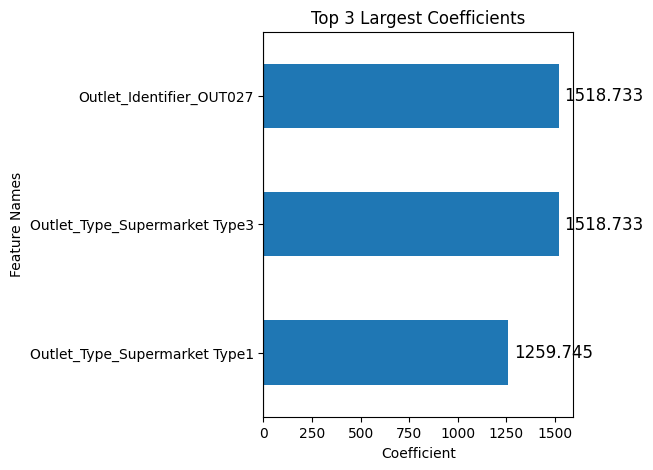

In [508]:
plot_coeffs(coeffs,top_n=3,intercept=False,annotate=True);

- Although the data isn't quite calibrated properly, the three most impactful features are:
  - Outlet_Identifier_OUT013
  - Outlet_Type_Supermarket Type 1
  - Outlet_Location_Type_Tier 3

### Random Forest Model

In [509]:
# Instantiate default random forest model
rf = RandomForestRegressor(random_state = 42)
# Model Pipeline
rf_pipe = make_pipeline(col_transformer, rf)

In [510]:
# Fit the model pipeline on the training data only
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_va...
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'Large']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size'])],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [511]:
# Use custom function to evaluate default model
def_rf_scores = evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test, model_name = 'Default Random Tree')
def_rf_scores

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Default Random Tree,296.92,774.51,428.51,"1,110.39",0.94,0.55


- This model is clearly signiicantly overfit.
- The training R^2 value is .9384, while the test value is only .5604.
- Variance this high can be resolved by adjusting the hyperparameters of our model to resolve the overfitting and reduce variance.

3. Use GridSearchCV to tune at least two hyperparameters for a Random Forest model.

- After determining the best parameters from your GridSearch, fit and evaluate a final best model on the entire training set (no folds).
- Compare your tuned model to your default Random Forest: did the performance improve

## Inspecting 5 most important features

In [512]:
# Saving the feature importances
feature_importance = pd.Series(rf.feature_importances_, index=feature_names,
                        name='Feature Importances')
feature_importance.head()

,Feature Importances
Item_Weight,0.06
Item_Visibility,0.10
Item_MRP,0.44
Outlet_Establishment_Year,0.04
Item_Category_FD,0.00


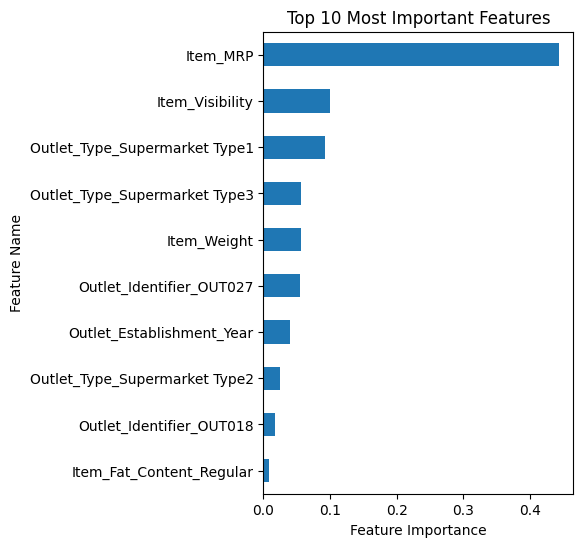

In [513]:
# plotting top 10 importances
ax = feature_importance.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Feature Importance',
       title='Top 10 Most Important Features');

- The five most important features are:
  - Item_MRP
  - Item_Visibility
  - Outlet_Type_Supermarket Type 1
  - Outlet_Type_Supermarket Type3
  - Item_weight

### Using GridSearchCV to tune Random Forest model

In [514]:
# Parameters for tuning
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
          'Outlet_Establishment_Year'],
         dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='MISSING',
                                                                   strategy='constant')),
                                                    (...
                                    Index(['Item_Category', 'Item_Fat_Content', 'Item_T

In [515]:
# Define param grid with options to try
params = {'randomforestregressor__max_depth': [3, 5, 8],
          'randomforestregressor__n_estimators':[1500, 2000, 2500],
          'randomforestregressor__min_samples_leaf':[2, 3],
          }
# Instantiate the gridsearch
gridsearch = GridSearchCV(rf_pipe, params, n_jobs=-1, cv = 3, verbose=1)
# Fit the gridsearch on training data
gridsearch.fit(X_train, y_train)
# Obtain best parameters
gridsearch.best_params_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


{'randomforestregressor__max_depth': 5,
 'randomforestregressor__min_samples_leaf': 2,
 'randomforestregressor__n_estimators': 2500}

In [516]:
# Define and refit best model
best_rf = gridsearch.best_estimator_
best_rf_scores = evaluate_regression(best_rf, X_train, y_train, X_test, y_test, model_name = 'Tuned Random Tree Model')
best_rf_scores

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Tuned Random Tree Model,749.23,727.83,"1,061.33","1,046.72",0.62,0.60


- After tuning the model the performance improved significantly.
-

## CRISP-DM Phase 5 - Evaluation





4. You now have tried several different models on your data set. You need to determine which model to implement.

- Overall, which model do you recommend?
- Justify your recommendation.
- In a Markdown cell:
  - Interpret your model's performance based on R-squared in a way that your non-technical stakeholder can understand.
  - Select another regression metric (RMSE/MAE/MSE) to express the performance of your model to your stakeholder.
  - Include why you selected this metric to explain to your stakeholder.
  - Compare the training vs. test scores and answer the question: to what extent is this model overfit/underfit?

In [517]:
# Grouping each model
scores_df = pd.concat([best_rf_scores, def_rf_scores, lin_reg_scores])
# Ordering by highest test_R2
scores_df.sort_values(by='test_R2')

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Default Random Tree,296.92,774.51,428.51,"1,110.39",0.94,0.55
Linear Regression,847.12,804.10,"1,139.10","1,092.85",0.56,0.57
Tuned Random Tree Model,749.23,727.83,"1,061.33","1,046.72",0.62,0.60


In [518]:
# Ordering by
scores_df.sort_values(by='test_RMSE')

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Tuned Random Tree Model,749.23,727.83,"1,061.33","1,046.72",0.62,0.60
Linear Regression,847.12,804.10,"1,139.10","1,092.85",0.56,0.57
Default Random Tree,296.92,774.51,428.51,"1,110.39",0.94,0.55


- The model I recommend most would be the best_rf_scores, optimized random tree model.

Analyzing R^2
- That model had the lowest variance, while also having the lowest bias.
- The optimized random tree model had a test R^2 score of .6033, much higher than that of the other models.
- The R^2 of .6, means that the prediction will be roughly 40% off.

Analyzing RMSE
- We can see that the RMSE/Root Mean Squared Error, is also the lowest for our tuned random tree.
- The RMSE accentuates larger errors more than small errors. Having a smaller RMSE typically means the models errors won't be as extreme.

Is the Tuned Random Tree over/under fit?
- The model is not very overfit by any means, the R^2s for the test and training data aer within 1% of each other.
- Comparing MAE and RMSE will show that those values are also similar across training and testing data.
- Now the model can be considered underfit as the bias still seems fairly high.
- This could be due to a few reasons:
  - Not using a complex enough model.
  - 'Bad' data or data that still contains too much noise.
  - Using only the most relevant features to our target.

# TO DO
- Target Encoding
- Model Stacking
- Spell Check -
- Outlet_Location_Type data type(?)